In [1]:
import numpy as np
from numpy import sqrt
import matplotlib.pyplot as py
import getdist as gs
import os
import copy
from getdist import plots, loadMCSamples
from pathlib import Path

In [2]:
def vect(x, y, M, m):
    xdot = y
    ydot = -((3)**0.5)*y*(0.5*(y**2) + M*(x**m))**0.5 - m*(x**(m-1))*M
    return xdot, ydot

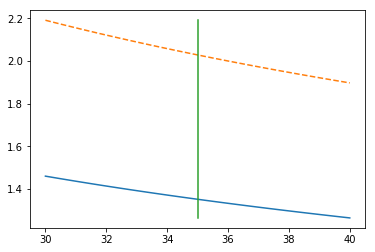

In [3]:
h60 = 2
k = 0.5
linechoice = 35

phi60 = np.linspace(30, 40, 101)
Vzero = [(h60**2)*2/(phi**k) for phi in phi60]
Vzero2 = [(h60**2)*3/(phi**k) for phi in phi60]

py.plot(phi60, Vzero)
py.plot(phi60, Vzero2, '--')
py.plot(np.linspace(linechoice, linechoice, 11), np.linspace(Vzero[-1], Vzero2[0], 11))

In [4]:
def traj(xstart, ystart, M, m, dt=0.001, no_iter = 1000):
    T = int(no_iter/dt)
    t = np.zeros(no_iter + 1)
    x = np.zeros(no_iter + 1)
    y = np.zeros(no_iter + 1)
    x[0]  =xstart
    y[0] = ystart
    n=0
    while n<no_iter:
        X1, Y1 = vect(x[n], y[n], M, m)
        X2, Y2 = vect(x[n] + 0.5*dt*X1, y[n] + 0.5*dt*Y1, M, m)
        X3, Y3 = vect(x[n] + 0.5*dt*X2, y[n] + 0.5*dt*Y2, M, m)
        X4, Y4 = vect(x[n] + dt*X3, y[n] + dt*Y3, M, m)
        gradx, grady = (X1 + 2*X2 + 2*X3 + X4)/6, (Y1 + 2*Y2 + 2*Y3 + Y4)/6
        x[n+1], y[n+1] = x[n] + gradx*dt, y[n] + grady*dt
        t[n+1] = t[n] + dt
        n += 1
    return t, x, y

grad_calc = lambda H, V0, phi, m: (abs(1.5*(H**2) - 0.5*V0*(phi**m)))**0.5
grad_sqr = lambda H, V0, phi, m: 1.5*(H**2) - 0.5*V0*(phi**m)
epsilon_calc = lambda  H, V0, phi, m: 2*(abs(1.5*(H**2) - 0.5*V0*(phi**m))/(H**2))
def f(H, V0, phi, m):
                                         returnval = (0.5**((0.0001/epsilon_calc(H, V0, phi, m)))) if epsilon_calc(H, V0, phi, m) < 0.0001 else 0.5
                                         return returnval

def trajectory(V_0, k, phi_0, dphi0 = 0.0001, boundmultiplier = 100, H0 = 2.5, suppress = False):
    if not (3*(H0**2)/((phi_0)**k) > V_0 > 2*(H0**2)/((phi_0)**k) or suppress):
        raise Exception("wrong parameter choice")
    T =  int(phi_0/dphi0)
    phi = np.zeros(boundmultiplier*T+1)  #adapting mesh for phi
    H = np.zeros(boundmultiplier*T+1)
    phi[0] = phi_0
    H[0]  = H0
    epsilon = epsilon_calc(H[0], V_0, phi[0], k)
    n = 0
    dphi = dphi0
    #SPACE
    while (epsilon < 1) and (n < boundmultiplier*T):
        K1 = grad_calc(H[n], V_0, phi[n], k)
        K2 = grad_calc(H[n] - 0.5*dphi*K1, V_0, phi[n] - 0.5*dphi, k)
        K3 = grad_calc(H[n] - 0.5*dphi*K2, V_0, phi[n] - 0.5*dphi, k)
        K4 = grad_calc(H[n] - dphi*K3, V_0, phi[n] - dphi, k)
        grad = (K1 + 2*K2 + 2*K3 + K4)/6
        H[n+1] = H[n] - dphi*grad
        phi[n+1] = phi[n] - dphi
        epsilon = epsilon_calc(H[n+1], V_0, phi[n+1], k)
        dphi = min(0.5*(H[n+1] - ((V_0*(phi[n+1])**k)*(1/3))**0.5)/(grad_calc(H[n+1], V_0, phi[n+1], k)), dphi0)
        n += 1
    return phi[0:n+1], H[0:n+1], n, epsilon

def tot_traj(Nstart, V_0, k, phi_0 = 10, dphi0 = 0.0001, boundmultiplier = 100, H0 = 2.5, suppress = False, epsilonstop = False):
    T = int(phi_0/dphi0)
    gradpositive = True
    phiswap, Jswap, n0, epsilon = trajectory(V_0, k, phi_0, dphi0, boundmultiplier, H0, suppress)
    #swap order of phi array and H array - we are about to integrate backwards in time
    phi1, J1 = phiswap[::-1], Jswap[::-1]
    #We start at the end of inflation, so we start at N = 0
    #Initialise arrays to bound the memory we will need
    N = np.zeros(boundmultiplier*T + 1)
    phi = np.zeros(boundmultiplier*T + 1)
    H = np.zeros(boundmultiplier*T + 1)
    ε = np.zeros(boundmultiplier*T + 1)
    #we have our phi values up to phi_0 and the corresponding H values already
    phi[:n0 + 1] = phi1
    H[:n0 + 1] = J1
    #assign epsilon at the start of the scheme, the end of infaltion
    ε[0] = epsilon
    #Initialise number of steps n
    n = 0
    n_sgn_change = boundmultiplier*T + 1
    while (N[n] < Nstart) and (n < n0):
        #Here we are just reparametrising the H trjectory we already have
        dphi = phi[n+1] - phi[n]
        ε[n+1] = epsilon_calc(H[n+1], V_0, phi[n+1], k)
        E1 = (2 / ε[n])**0.5
        E2 = (2 / ε[n+1])**0.5
        N[n+1] = N[n] + dphi*(E1 + E2)/4
        n += 1
    #check to see if we will have a non-sensical H'
    while gradpositive and (N[n] < Nstart) and (n < boundmultiplier*T) and (ε[n] < 1 or not epsilonstop):
        while (N[n] < Nstart) and (n < boundmultiplier*T) and (ε[n] < 1 or not epsilonstop):
            #The next check allows us to skip time consuming checks if epsilon is clearly still not close to zero
            if ε[n] > 0.001:
                dphi = min(0.5*(H[n] - ((V_0*(phi[n])**k)*(1/3))**0.5)/(grad_calc(H[n], V_0, phi[n], k)), dphi0)
                K1 = grad_calc(H[n], V_0, phi[n], k)
                K2 = grad_calc(H[n] + 0.5*dphi*K1, V_0, phi[n] + 0.5*dphi, k)
                K3 = grad_calc(H[n] + 0.5*dphi*K2, V_0, phi[n] + 0.5*dphi, k)
                K4 = grad_calc(H[n] + dphi*K3, V_0, phi[n] + dphi, k)
                grad = (K1 + 2*K2 + 2*K3 + K4)/6
                H[n+1] = H[n] + dphi*grad
                phi[n+1] = phi[n] + dphi
                ε[n+1] = epsilon_calc(H[n+1], V_0, phi[n+1], k)
                #SPACE
                E1 = (2 / ε[n])**0.5
                E2 = (2 / ε[n+1])**0.5
                N[n+1] = N[n] + dphi*(E1 + E2)/4
                n += 1
            else:
                #else we check at each stage whether we are going to pass phidot = 0, in which case we note this
                #and continue so that we may return to assume a change in sign
                coeff = f(H[n], V_0, phi[n], k)
                dphi = min(coeff*(H[n] - ((V_0*(phi[n])**k)*(1/3))**0.5)/(grad_calc(H[n], V_0, phi[n], k)), dphi0)
                if grad_sqr(H[n], V_0, phi[n], k) > 0:
                    K1 = grad_calc(H[n], V_0, phi[n], k)
                else:
                    gradpositive = False
                    break
                if grad_sqr(H[n] + 0.5*dphi*K1, V_0, phi[n] + 0.5*dphi, k):
                    K2 = grad_calc(H[n] + 0.5*dphi*K1, V_0, phi[n] + 0.5*dphi, k)
                else:
                    gradpositive = False
                    break
                if grad_sqr(H[n] + 0.5*dphi*K2, V_0, phi[n] + 0.5*dphi, k):
                    K3 = grad_calc(H[n] + 0.5*dphi*K2, V_0, phi[n] + 0.5*dphi, k)
                else:
                    gradpositive = False
                    break
                if grad_sqr(H[n] + dphi*K3, V_0, phi[n] + dphi, k):
                    K4 = grad_calc(H[n] + dphi*K3, V_0, phi[n] + dphi, k)
                else:
                    gradpositive = False
                    break
                grad = (K1 + 2*K2 + 2*K3 + K4)/6
                H[n+1] = H[n] + dphi*grad
                phi[n+1] = phi[n] + dphi
                ε[n+1] = epsilon_calc(H[n+1], V_0, phi[n+1], k)
                #SPACE
                J1 = (2 / ε[n])**0.5
                J2 = (2 / ε[n+1])**0.5
                N[n+1] = N[n] + dphi*(J1 + J2)/4
                n += 1
    #once we note the change in sign, we approximate phi constant, H' takes the negative of its last value,so H is unchanged
    if (N[n] < Nstart) and (n < boundmultiplier*T) and (ε[n] < 1 or not epsilonstop):
        dphi = min(0.5*(H[n-1] - ((V_0*(phi[n-1])**k)*(1/3))**0.5)/(grad_calc(H[n-1], V_0, phi[n-1], k)), dphi0)
        K1 = -grad_calc(H[n-1], V_0, phi[n-1], k)
        K2 = -grad_calc(H[n-1] + 0.5*dphi*K1, V_0, phi[n-1] + 0.5*dphi, k)
        K3 = -grad_calc(H[n-1] + 0.5*dphi*K2, V_0, phi[n-1] + 0.5*dphi, k)
        K4 = -grad_calc(H[n-1] + dphi*K3, V_0, phi[n-1] + dphi, k)
        grad = (K1 + 2*K2 + 2*K3 + K4)/6
        H[n] = H[n-1] - dphi*grad
        phi[n] = phi[n-1] - dphi
        ε[n] = epsilon_calc(H[n], V_0, phi[n], k)
        n_sgn_change = n
        #SPACE
        E1 = (2 / ε[n-1])**0.5
        E2 = (2 / ε[n])**0.5
        N[n] = N[n-1] + dphi*(E1 + E2)/4
    while (N[n] < Nstart) and (n < boundmultiplier*T) and (ε[n] < 1 or not epsilonstop):
        dphi = min(0.5*(H[n] - ((V_0*(phi[n])**k)*(1/3))**0.5)/(grad_calc(H[n], V_0, phi[n], k)), dphi0)
        K1 = -grad_calc(H[n], V_0, phi[n], k)
        K2 = -grad_calc(H[n] + 0.5*dphi*K1, V_0, phi[n] + 0.5*dphi, k)
        K3 = -grad_calc(H[n] + 0.5*dphi*K2, V_0, phi[n] + 0.5*dphi, k)
        K4 = -grad_calc(H[n] + dphi*K3, V_0, phi[n] + dphi, k)
        grad = (K1 + 2*K2 + 2*K3 + K4)/6
        H[n+1] = H[n] - dphi*grad
        phi[n+1] = phi[n] - dphi
        ε[n+1] = epsilon_calc(H[n+1], V_0, phi[n+1], k)
        #SPACE
        E1 = (2 / ε[n])**0.5
        E2 = (2 / ε[n+1])**0.5
        N[n+1] = N[n] + dphi*(E1 + E2)/4
        n += 1
    return phi[:n+1], H[:n+1], n, ε[:n+1], N[:n+1], n_sgn_change

phi1 = lambda C, r0, m: 8*sqrt(2)*(r0 - 48)*m/(sqrt(r0)*(C*r0 - 16*C - r0 - 176))
phidot1 = lambda C, r0, m, V0: (V0**0.5)*sqrt(-2*(r0 - 48)*((8*sqrt(2)*(r0 - 48)*m/(sqrt(r0)*(C*r0 - 16*C - r0 - 176)))**m)*r0)/(r0 - 48)

phi2 = lambda C, r0, m: -8*sqrt(2)*(r0 - 48)*m/(sqrt(r0)*(C*r0 - 16*C - r0 - 176))
phidot2 = lambda C, r0, m: (V0**0.5)*sqrt(-2*(r0 - 48)*(-8*sqrt(2)*(r0 - 48)*m/(sqrt(r0)*(C*r0 - 16*C - r0 - 176)))**m*r0)/(r0 - 48)

phi3 = lambda C, r0, m: 24*sqrt(2)*(r0 - 48)*m/(sqrt(r0)*(3*C*r0 - 48*C + 25*r0 - 528))
phidot3 = lambda C, r0, m: (V0**0.5)*sqrt(-2*(r0 - 48)*(24*sqrt(2)*(r0 - 48)*m/(sqrt(r0)*(3*C*r0 - 48*C + 25*r0 - 528)))**m*r0)/(r0 - 48)

In [5]:
#paths are written as the following
pathbase = "C:/Users/Jacob/Documents/aWarwicka/4y_project/Python_tasks/Getdist/base_r/plikHM_TTTEEE_lowl_lowE"
dirs = os.listdir(pathbase)
#os.listdir returns a list of strings
basepth = "C:/Users/Jacob/Documents/aWarwicka/4y_project/Python_tasks/Getdist/base_r/plikHM_TTTEEE_lowl_lowE"
root = "base_r_plikHM_TTTEEE_lowl_lowE"

samps = loadMCSamples(os.path.join(basepth, root), settings={'ignore_rows':0.3})

sampscopy = copy.deepcopy(samps)
params = samps.getParams()

C:\Users\Jacob\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


NameError: name 'V0choice' is not defined

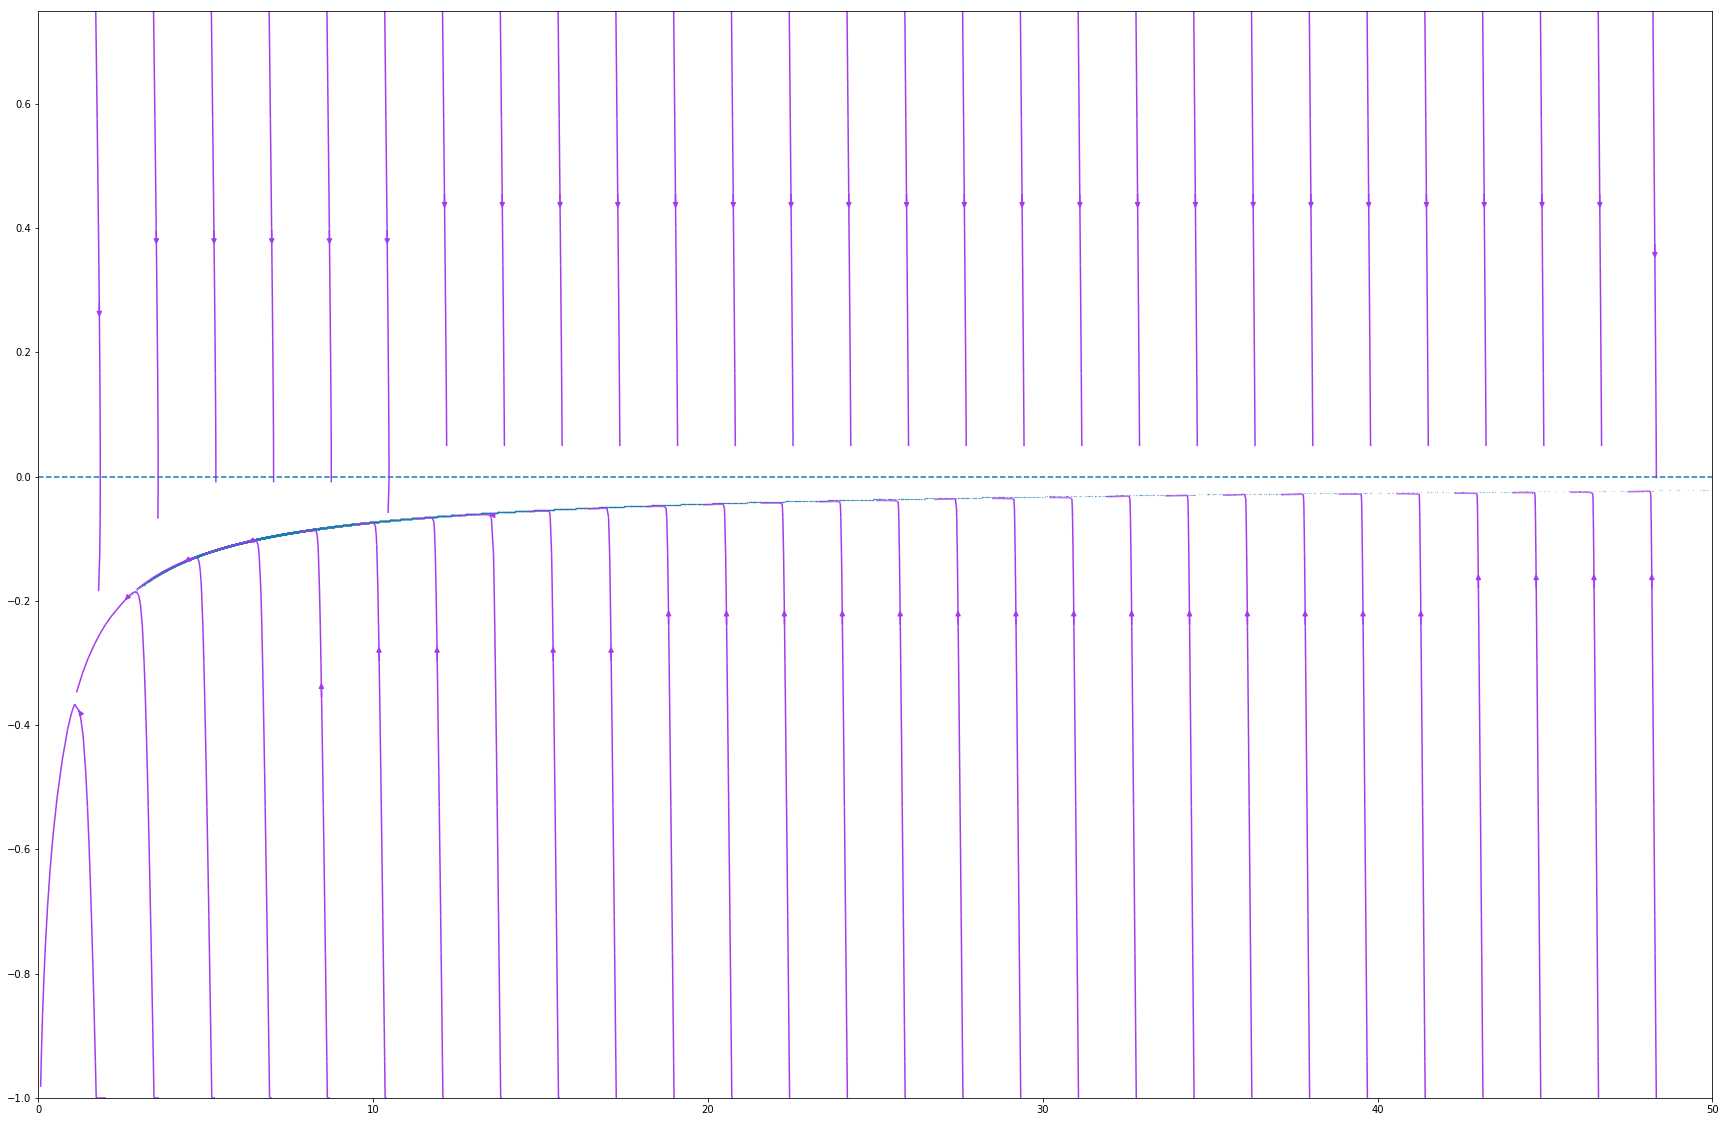

In [6]:
kchoice = 0.5
initphi = 50
inith = 2
M = ((inith**2)*2.99998)/(35**kchoice)

ybound = 1
nx, ny = 1024, 1024
x = np.linspace(0, initphi, nx)
y = np.linspace(-ybound, 0.75*ybound, ny)
X, Y = np.meshgrid(x, y)

plane = py.figure(figsize=(30, 20)) 
py.streamplot(X, Y, vect(X, Y, M, kchoice)[0], vect(X, Y, M, kchoice)[1], density=1.0, linewidth=None, color='#A23BEC')
py.plot(np.linspace(0, initphi, 101), np.zeros(101), '--')

phi1_scatter = [phi1(ns, r, kchoice) for [ns, r] in zip(params.ns, params.r)]
phidot1_scatter = [phidot1(ns, r, kchoice, M) for [ns, r] in zip(params.ns, params.r)]
py.scatter(phi1_scatter, phidot1_scatter, s = 0.01)
py.xlim([0, initphi])

phi, H, n, epsilon, N, n_sgn = tot_traj(80, M, kchoice, phi_0 = 35, H0 = inith, suppress = False, epsilonstop = True)
Vset = [V0choice*ϕ**kchoice for ϕ in phi]
phidot = [-(6*((H[i])**2) - 2*(Vset[i]))**0.5 if i<n_sgn else (6*((H[i])**2) - 2*(Vset[i]))**0.5 for i in range(len(phi))]
py.plot(phi, phidot, label='HJ trajectory')
#py.plot(phi, epsilon, label='ε')
py.xlabel('ϕ')
py.legend()
print("n =", n, end = '\n')
print("N =", N[-1], end = '\n')
for i, el in enumerate(epsilon):
    if el >1 and i>0:
        print("Full trajectory not available via this method - ε > 1 at n = %s"%i)
        break
        

https://stackoverflow.com/questions/37798645/how-add-plot-to-subplot-matplotlib

C:\Users\Jacob\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


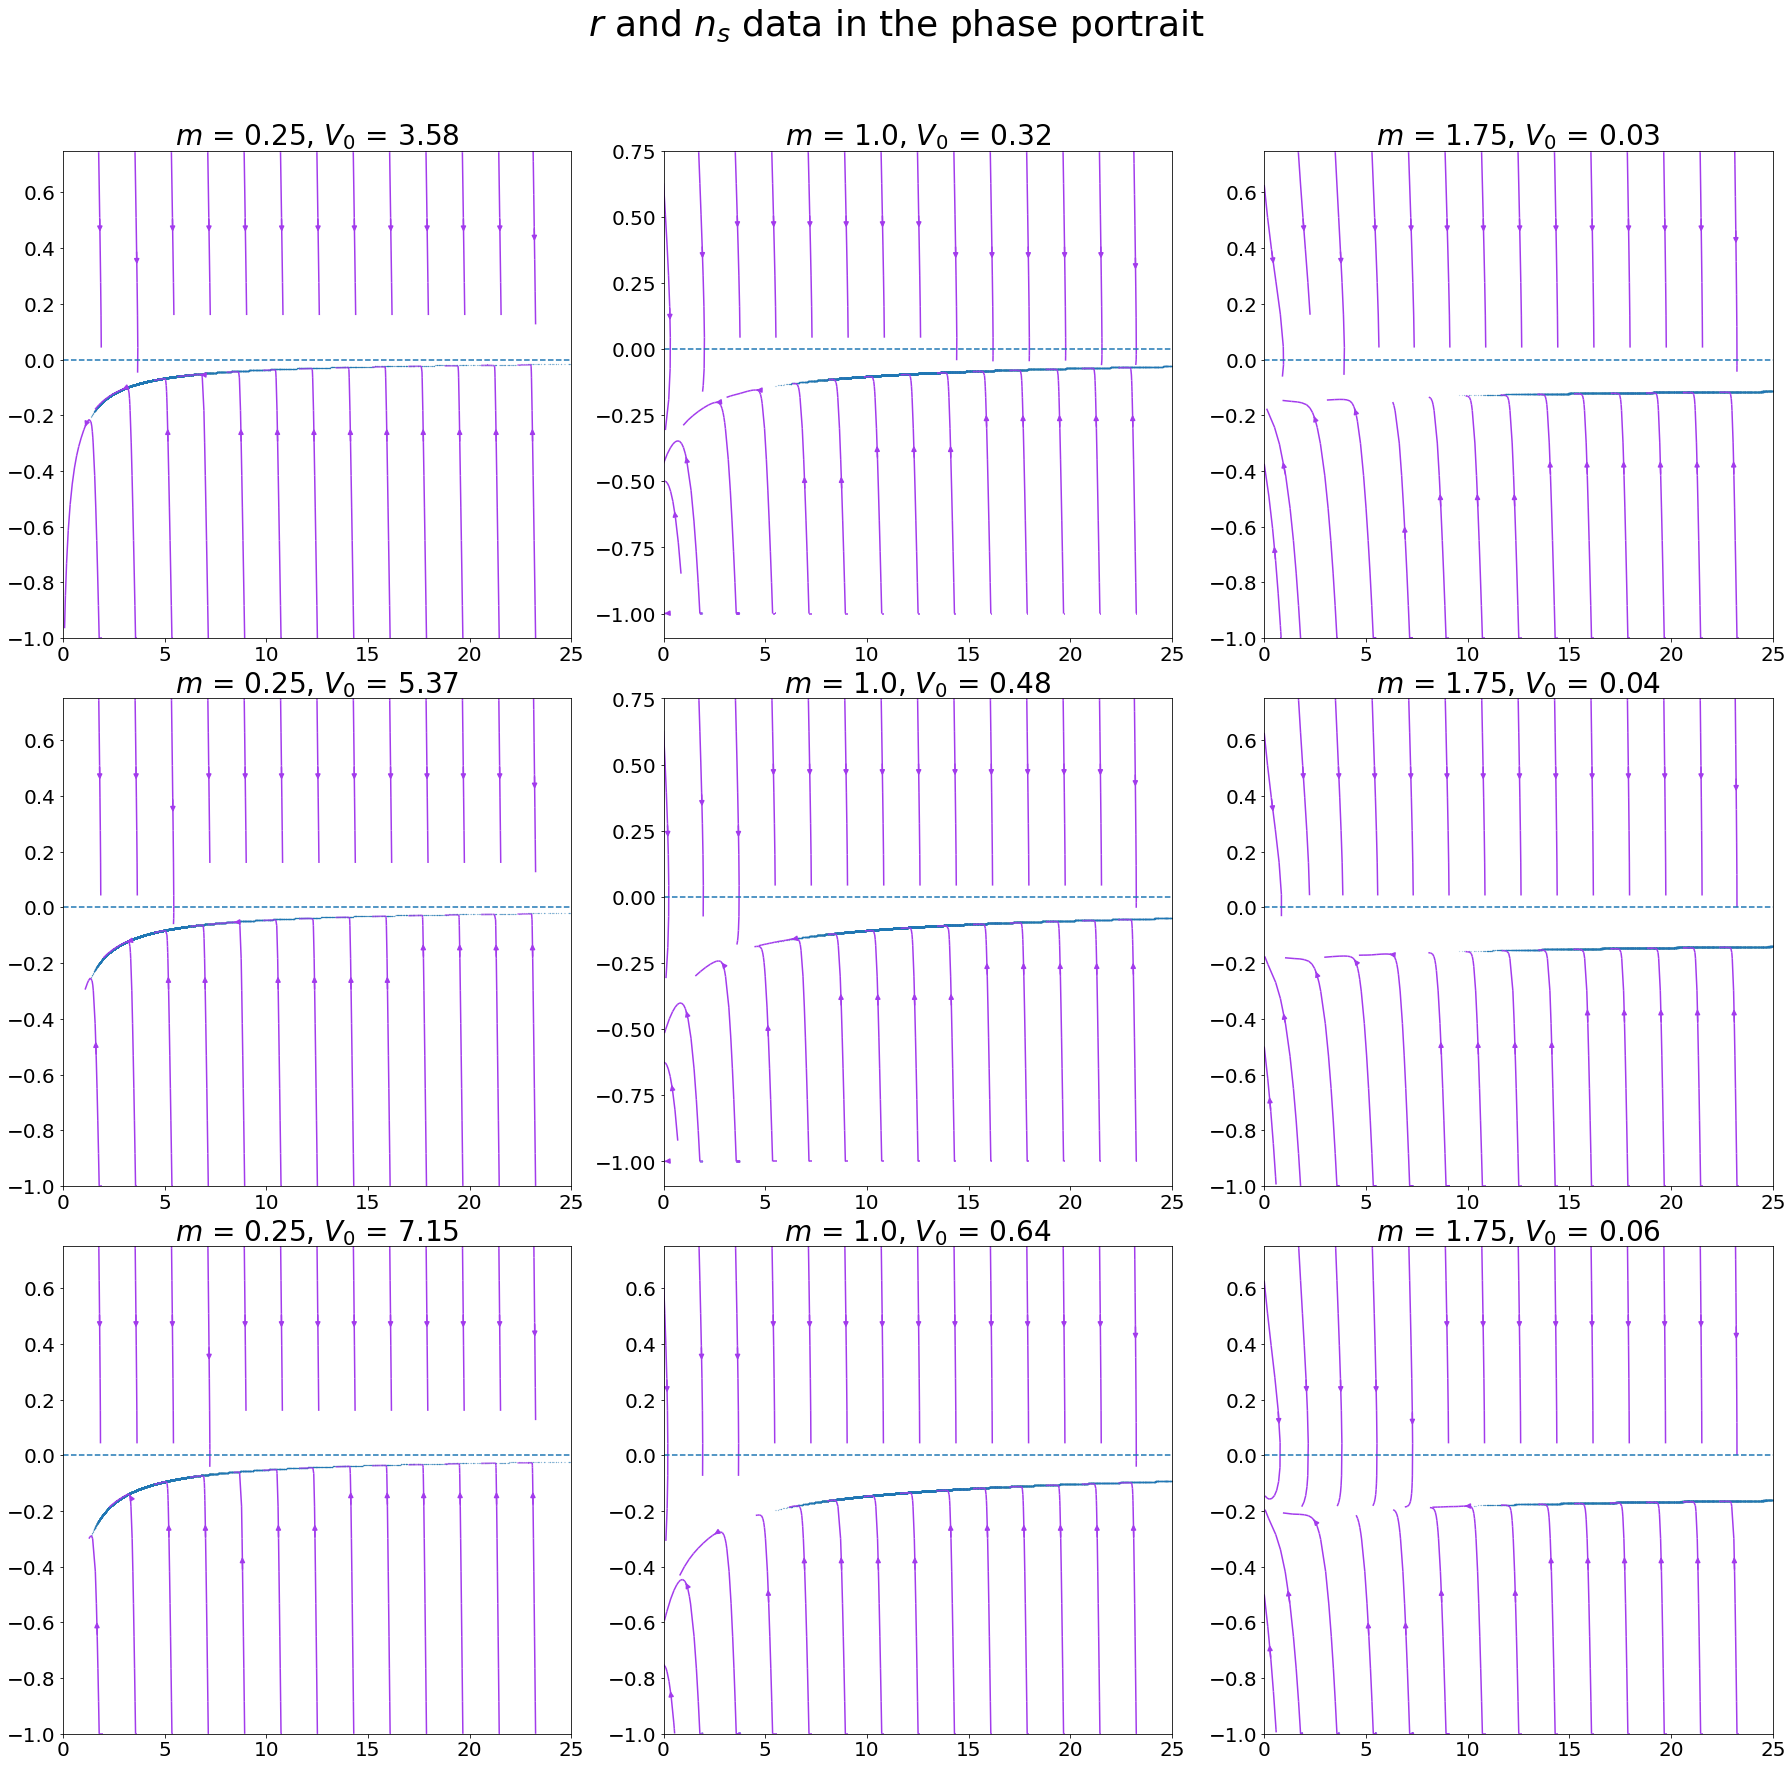

In [16]:
inith = 2
initphi = 25.0

nx, ny = 1024, 1024
x = np.linspace(0, initphi, nx)
y = np.linspace(-ybound, 0.75*ybound, ny)

plane, ax = py.subplots(3, 3, figsize = (25, 25))
plane.suptitle('$r$ and $n_s$ data in the phase portrait', size = 36)

for i in range(3):
    for j in range(3):
        m = 0.75*i + 0.25
        V0 = ((inith**2)*2/(initphi**m))*1.0001*(1-j) + (j)*0.9999*(inith**2)*3/(initphi**m)
        X, Y = np.meshgrid(x, y)
        py.sca(ax[j, i])
        py.streamplot(X, Y, vect(X, Y, V0, m)[0], vect(X, Y, V0, m)[1], density=0.5, linewidth=None, color='#A23BEC')
        ax[j,i].plot(np.linspace(0, initphi, 11), np.zeros(11), '--')
        #space
        phi1_scatter = [phi1(ns, r, m) for [ns, r] in zip(params.ns, params.r)]
        phidot1_scatter = [phidot1(ns, r, m, V0) for [ns, r] in zip(params.ns, params.r)]
        ax[j,i].scatter(phi1_scatter, phidot1_scatter, s = 0.01)
        ax[j,i].set_xlim([0, initphi])
        string = '$m$ = ' + str(m) + ', $V_0$ = ' + str(round(V0, 2))
        py.title(string, size = 28)
plane.tight_layout()
plane.subplots_adjust(top=0.9)

        

In [17]:
plane.savefig('m_025_025_5_V0_6.png')